# Packet-Scheduling with Reinforcement Learning

**Objective**  
Build and compare:
1. A custom Gym env for three-class packet scheduling (video/voice/best-effort).  
2. Three fixed scheduling policies (FIFO, EDF, Sequential Priority).  
3. A tabular Q-learning agent that meets hard-deadline constraints on P1/P2 while minimizing P3 delay for scenario 1.


**Notebook roadmap**  
1. [Problem formulation (MDP)](#formulation)  
2. [Environment implementation](#env)  
3. [Baseline policies](#baselines)  
4. [Reinforcement-learning agent](#rl-agent)  
5. [Results & comparison](#results)  
6. [Conclusions](#conclusion)  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from gymnasium import Env, spaces
from gymnasium.utils import seeding
from IPython.display import clear_output
import time
from collections import defaultdict, deque
import random
import pandas as pd

ModuleNotFoundError: No module named 'ace_tools'

### Environment & Problem Description

**Traffic Classes**  
There are three traffic classes:  
- **P1 (Video)** uses hard QoS with a delivery deadline of 6 time-steps.  
- **P2 (Voice)** uses hard QoS with a delivery deadline of 4 time-steps.  
- **P3 (Best-Effort)** uses soft QoS and has no strict deadline.

**State Space**  
- **Scenario 1:** The state is the vector of queue lengths \((q₁, q₂, q₃)\), where each \(qᵢ ∈ \{0,1,…, \text{max\_queue\_len}\}\).  
- **Scenario 2:** The state includes both the queue lengths and the index of the currently selected queue: \((q₁, q₂, q₃, c)\), with \(c ∈ \{0,1,2\}\) indicating which queue would be served if no switch occurs.

**Action Space**  
- In both scenarios the agent chooses one of three discrete actions \(a ∈ \{0,1,2\}\), corresponding to serving P1, P2 or P3.  
- **Scenario 1:** Action \(a\) immediately serves one packet from queue \(a\) (or incurs an empty-serve penalty if that queue is empty).  
- **Scenario 2:** If \(a\) matches the current queue index \(c\), a packet is served; otherwise the agent spends the step switching (updates \(c = a\)) and no packet is served this time step.

### Imports

## 2. PacketSchedulerEnv

We implement a Gym Env with:
- Poisson arrivals (λ₁=0.3, λ₂=0.25, λ₃=0.4)
- Three FIFO queues with per-queue QoS limits [6,4,None]
- Two scenarios:  
  1. Low-spec router (three actions available -- switch queue, serve queue, and do nothing -- both with cost of one timeslot)  
  2. High-spec router (two actiona available -- switch queue and serve, serve current queue, and do nothing -- both of which have a cost of one timeslot) *still need to implement*

In [3]:
class PacketSchedulerEnv(Env):
    """
    OpenAI Gymnasium environment simulating packet scheduling across three queues:
    """

    def __init__(self, scenario=1, arrival_probs = [0.3, 0.25, 0.4], seed = None) :
        """
        Constructor
        takes the scenario 1 or 2 as arguments
        """
        super().__init__()
        self.num_queues = 3
        self.max_queue_size = 50
        self.scenario = scenario
        self.current_queue = 0  # Only used in scenario 2
        self.time = 0
        self.empty_serving = 0

        self.qos_limits = [6, 4, None]  # Video, Voice, Best-Effort
        self.arrival_probs = arrival_probs

        self.observation_space = spaces.Box(
            low=0, high=self.max_queue_size, shape=(self.num_queues,), dtype=np.int32
        )
        self.action_space = spaces.Discrete(3)
        ## seed control
        self.global_seed = seed
        self._apply_global_seed(seed)

        self.episode_rewards = []
        self.reset()

    def _apply_global_seed(self, seed):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            self.action_space.seed(seed)
            self.observation_space.seed(seed)

    def reset(self, seed=None, options=None):
        real_seed = seed if seed is not None else self.global_seed
        self._apply_global_seed(real_seed)
        self.current_queue = np.random.choice([0, 1, 2])
        self.arrival_counts = [0 for _ in range(self.num_queues)]
        self.queues = [[] for _ in range(self.num_queues)]
        self.time = 0
        self.history = []
        self.served_delays = [[] for _ in range(self.num_queues)]
        self.violations = [0, 0]
        self.total_episode_reward = 0
        self.empty_serving = 0
        return self.get_observations(), {}

    def get_observations(self):
        return np.array([len(q) for q in self.queues])

    def generate_packets(self):
        for queue_id, rate in enumerate(self.arrival_probs):
            if np.random.rand() < rate:
                if len(self.queues[queue_id]) < self.max_queue_size:
                    self.queues[queue_id].append(self.time)
                    self.arrival_counts[queue_id] += 1

    def queue_has_packets(self, queue_idx):
        return len(self.queues[queue_idx]) > 0

    def compute_packet_delay(self, arrival_time):
        return self.time - arrival_time

    def compute_reward(self, queue_idx, delay):
        if self.scenario == 2:
            return self.compute_reward_scenario2(queue_idx, delay)
        # Scenario 1 reward
        qos_limit = self.qos_limits[queue_idx]
        if qos_limit is not None:
            if delay <= qos_limit:
                time_left_ratio = (qos_limit - delay) / qos_limit
                urgency_bonus = 2.0 * (1 - time_left_ratio)
                return 3.5 + urgency_bonus if queue_idx == 0 else 4.0 + urgency_bonus
            else:
                violation_ratio = (delay - qos_limit) / qos_limit
                return max(-10.0, -6.0 * (1 + violation_ratio ** 1.5))
        else:
            return max(0.1, 1.2 - 0.03 * delay)

    def compute_reward_scenario2(self, queue_idx, delay):
        qos_limit = self.qos_limits[queue_idx]
        fairness_penalty = 0.0
        # Penalize all queues with long lengths
        for idx in range(self.num_queues):
            qlen = len(self.queues[idx])
            if qlen > 10:
                fairness_penalty -= 1.5 * (qlen - 10)
        # Bonus for serving starved queues
        if len(self.queues[queue_idx]) > 10:
            fairness_penalty += 5.0
        # Additional logic for BE queue when urgent packets exist
        if queue_idx == 2:
            urgent_video = bool(self.queues[0]) and (self.qos_limits[0] - (self.time - self.queues[0][0]) <= 1)
            urgent_voice = bool(self.queues[1]) and (self.qos_limits[1] - (self.time - self.queues[1][0]) <= 1)
            if urgent_video or urgent_voice:
                return -50.0 + fairness_penalty
            return max(0.1, 1.0 - 0.04 * delay) + fairness_penalty
        if qos_limit is not None:
            if delay <= qos_limit:
                return (15.0 - 2.0 * (qos_limit - delay)) + fairness_penalty
            else:
                return -100.0 + fairness_penalty
        return 0.1 + fairness_penalty

    def serve_queue(self, queue_idx):
        if not self.queue_has_packets(queue_idx):
            self.empty_serving += 1
            return -2.0  # Penalty for serving empty queue
        arrival_time = self.queues[queue_idx].pop(0)
        delay = self.compute_packet_delay(arrival_time)
        self.served_delays[queue_idx].append(delay)
        if queue_idx < 2 and delay > self.qos_limits[queue_idx]:
            self.violations[queue_idx] += 1
        return self.compute_reward(queue_idx, delay)

    def process_action(self, action):
        if self.scenario == 1:
            return self.process_action_scenario1(action)
        elif self.scenario == 2:
            return self.process_action_scenario2(action)

    def process_action_scenario1(self, action):
        # Serve directly selected queue (0,1,2)
        return action, 0

    def process_action_scenario2(self, action):
        # Action 0: Serve current queue, Action 1: Switch (with penalty)
        if action == 1:
            penalty = 0.0
            self.current_queue = (self.current_queue + 1) % self.num_queues
            self.time += 1
            return None, penalty
        else:
            return self.current_queue, 0

    def step(self, action):
        self.generate_packets()
        if self.scenario == 1:
            selected_queue, reward = self.process_action_scenario1(action)
            if selected_queue is not None:
                serve_reward = self.serve_queue(selected_queue)
                reward += serve_reward
                self.time += 1
            reward += self.compute_starvation_penalty()
        elif self.scenario == 2:
            selected_queue, reward = self.process_action_scenario2(action)
            if selected_queue is not None:
                serve_reward = self.serve_queue(selected_queue)
                reward += serve_reward
                self.time += 1
            reward += self.compute_starvation_penalty()
        self.total_episode_reward += reward
        return self.get_observations(), reward, self._check_done(), False, {}

    def compute_starvation_penalty(self):
        starvation_penalty = 0.0
        for i, q in enumerate(self.queues):
            if q:
                head_age = self.time - q[0]
                if self.qos_limits[i] is not None:
                    threshold = 0.3 * self.qos_limits[i]
                    if head_age > threshold:
                        starvation_penalty -= 3.0 * ((head_age - threshold) / self.qos_limits[i])
                else:
                    if len(q) > 10:
                        starvation_penalty -= 0.1 * (len(q) - 10)
        return starvation_penalty

    def draw_network_queue(self):
        queue_lengths = [len(q) for q in self.queues]
        self.history.append(queue_lengths)
        clear_output(wait=True)
        plt.figure(figsize=(5, 4))
        plt.bar(["Video", "Voice", "Best-Effort"], queue_lengths, color=["blue", "orange", "green"])
        plt.ylim(0, self.max_queue_size)
        plt.title(f"Time Step: {self.time}")
        plt.ylabel("Packets in Queue")
        plt.grid(True)
        plt.show()

    def get_statistics(self):
        mean_delays = [np.mean(q) if q else None for q in self.served_delays]
        violation_rates = [self.violations[i] / max(1, len(self.served_delays[i])) for i in range(2)]
        stats = {
            'queue_lengths': [len(q) for q in self.queues],
            'arrivals': self.arrival_counts.copy(),
            'served': [len(q) for q in self.served_delays],
            'mean_delays': mean_delays,
            'qos_violations': self.violations.copy(),
            'violation_rates': violation_rates,
            'empty_queue_penalty_count': self.empty_serving
        }
        # this is for debugging only
        # for i in range(self.num_queues):
        #     if stats['arrivals'][i] > 0 and stats['served'][i] == 0:
        #         print(f"WARNING: Queue {i} had arrivals ({stats['arrivals'][i]}) but was never served!")
        return stats

    def _check_done(self):
        return sum([len(q) for q in self.queues]) == 0 and sum(self.arrival_counts) > 0



### 2.1. Quick Environment Sanity Check

Instantiate the env with random policy for packet scheduling and print its initial statistics.

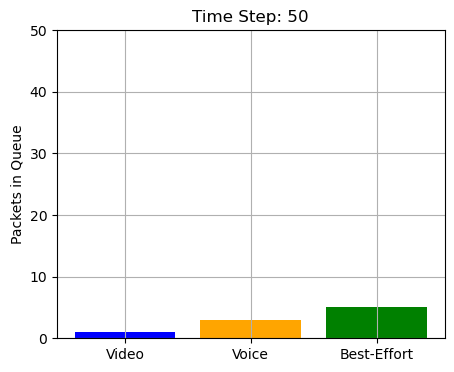

In [ ]:
env = PacketSchedulerEnv(scenario=1)
obs, _ = env.reset()

for _ in range(50):
    action = env.action_space.sample()  # Random policy
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()
    time.sleep(0.2)

In [5]:
env.get_statistics()

{'queue_lengths': [1, 3, 5],
 'arrivals': [14, 15, 15],
 'served': [13, 12, 10],
 'mean_delays': [5.6923076923076925, 4.833333333333333, 9.5],
 'qos_violations': [4, 6],
 'violation_rates': [0.3076923076923077, 0.5],
 'empty_queue_penalty_count': 15}

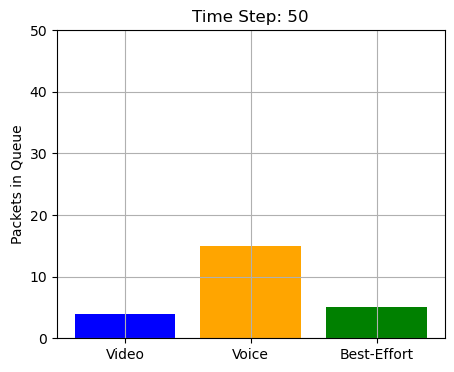

In [42]:
env = PacketSchedulerEnv(scenario=2)
obs, _ = env.reset()

for _ in range(50):
    action = env.action_space.sample()  # Random policy
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()
    time.sleep(0.2)

In [43]:
env.get_statistics()

{'queue_lengths': [4, 15, 5],
 'arrivals': [13, 18, 17],
 'served': [9, 3, 12],
 'mean_delays': [5.222222222222222, 43.666666666666664, 5.0],
 'qos_violations': [4, 3],
 'violation_rates': [0.4444444444444444, 1.0],
 'empty_queue_penalty_count': 8}

### Verification of Scenario 1 & 2 Implementations

The code cell below performs two targeted tests to confirm that **PacketSchedulerEnv** faithfully implements both scheduling modes:

1. **Scenario 1 (Immediate Serve):**  
   - With arrivals disabled (`arrival_probs=[0,0,0]`), we seed each queue with a known number of packets.  
   - Calling `step(a)` for each action `a` should immediately dequeue one packet from queue `a`.

2. **Scenario 2 (Switch-and-Serve):**  
   - We again disable arrivals and set initial queue lengths.  
   - First, we call `step(a)` with an action that differs from the current queue index. This should only update `current_queue` and **not** serve any packet.  
   - A subsequent `step(...)` call should then actually serve one packet from the newly selected queue.

After running the tests, the printed queue lengths and `current_queue` updates should match these expected behaviors exactly.

In [6]:
# ── Test that scenario 1 always serves immediately ──
# Create env with no new arrivals so we can control the queues
env1 = PacketSchedulerEnv(scenario=1, arrival_probs=[0,0,0], seed=0)
env1.reset()
# Manually initialise queues: 1 packet in P1, 2 in P2, 3 in P3
env1.queues = [[0], [0,0], [0,0,0]]

print("Scenario 1 — before any steps:", [len(q) for q in env1.queues])
for action in [0,1,2]:
    obs, reward, done, truncated, info = env1.step(action)
    print(f"  action={action} → served queue {action}, lengths now {[len(q) for q in env1.queues]}")

# ── Test that scenario 2 imposes a switching delay ──
env2 = PacketSchedulerEnv(scenario=2, arrival_probs=[0,0,0], seed=0)
env2.reset()
env2.queues = [[0], [0,0], [0,0,0]]
print("\nScenario 2 — before any steps:", [len(q) for q in env2.queues], "current_queue=", env2.current_queue)

# 1) Switch action (action==1): should change current_queue but not serve
obs, reward, done, truncated, info = env2.step(1)
print(f"  action=1 (switch) → current_queue={env2.current_queue}, lengths still {[len(q) for q in env2.queues]}")

# 2) Now any other action (e.g. 0) should serve from the new current_queue
obs, reward, done, truncated, info = env2.step(0)
print(f"  action=0 (serve) → served queue {env2.current_queue}, lengths now {[len(q) for q in env2.queues]}")

Scenario 1 — before any steps: [1, 2, 3]
  action=0 → served queue 0, lengths now [0, 2, 3]
  action=1 → served queue 1, lengths now [0, 1, 3]
  action=2 → served queue 2, lengths now [0, 1, 2]

Scenario 2 — before any steps: [1, 2, 3] current_queue= 0
  action=1 (switch) → current_queue=1, lengths still [1, 2, 3]
  action=0 (serve) → served queue 1, lengths now [1, 1, 3]


### Testing Stochastic Arrivals & Seed-Based Reproducibility

We’ll run the environment for a fixed number of steps, always “serving” an empty queue so that any change in queue length comes purely from the arrival process. By comparing two runs with the same seed and two with different seeds, we can confirm:

- **Reproducibility:** identical queue‐length sequences when the seed is fixed.  
- **Stochasticity:** differing sequences when the seed changes.  

When we run the code below we should expect to see:
- The first comparison prints True, confirming reproducibility under the same seed.
- The second comparison prints False, showing that different seeds produce different arrival patterns—demonstrating genuine stochasticity.

In [8]:
def sample_arrival_sequence(seed, steps=20):
    env = PacketSchedulerEnv(
        scenario=1,
        arrival_probs=(0.3, 0.25, 0.4),
        seed=seed
    )
    env.reset()
    lengths = []
    for _ in range(steps):
        # always serve queue 0 (empty) so arrivals drive changes
        env.step(0)
        # record the three queue lengths
        lengths.append(tuple(len(q) for q in env.queues))
    return lengths

# Two runs with the same seed
seq_a1 = sample_arrival_sequence(seed=42)
seq_a2 = sample_arrival_sequence(seed=42)

# One run with a different seed
seq_b = sample_arrival_sequence(seed=7)

print("Same seed reproducible? ", seq_a1 == seq_a2)
print("Different seed identical?  ", seq_a1 == seq_b)
print("\nFirst 5 time‐step queue lengths (seed=42):")
for i, st in enumerate(seq_a1[:5], 1):
    print(f" Step {i}: P1={st[0]}, P2={st[1]}, P3={st[2]}")

print("\nFirst 5 time‐step queue lengths (seed= 7):")
for i, st in enumerate(seq_b[:5], 1):
    print(f" Step {i}: P1={st[0]}, P2={st[1]}, P3={st[2]}")

Same seed reproducible?  True
Different seed identical?   False

First 5 time‐step queue lengths (seed=42):
 Step 1: P1=0, P2=1, P3=0
 Step 2: P1=0, P2=1, P3=1
 Step 3: P1=0, P2=1, P3=2
 Step 4: P1=0, P2=2, P3=2
 Step 5: P1=0, P2=3, P3=2

First 5 time‐step queue lengths (seed= 7):
 Step 1: P1=0, P2=0, P3=0
 Step 2: P1=0, P2=0, P3=0
 Step 3: P1=0, P2=0, P3=0
 Step 4: P1=0, P2=0, P3=1
 Step 5: P1=0, P2=0, P3=1


### Reward Design

The following is a description of the reward design as implemented in the gym environment:

At each time step, the agent’s reward is the sum of three terms:

1. **Action Reward**
   – Comes from `process_action_scenarioX(action)`.  
   – For example, the system may recieve a small positive bonus for staying on the same queue versus a switching cost to discourage cycling without serving.  

2. **Service Reward**  
   – Returned by `serve_queue(selected_queue)`.  
   – Reflects the relative QoS priorities (Voice is more important than Video and Video is more important than Best‐Effort).

3. **Starvation Penalty**
   – From `compute_starvation_penalty()`.  
   – A negative penalty if any queue has gone unserved for too long, to enforce fairness.

Below is a code snippet for clarity:

```python
def compute_reward(env, action):
    # 1) Action reward (switch vs. stay)
    selected_queue, act_r = env.process_action_scenarioX(action)

    # 2) Service reward (+ for serve, – for empty)
    serve_r = env.serve_queue(selected_queue) if selected_queue is not None else 0.0

    # 3) Starvation penalty
    starve_r = env.compute_starvation_penalty()

    return act_r + serve_r + starve_r

### Reward Parameterization & Justification

Below we tabulate the concrete values chosen for each term in the reward signal and describe the reasoning for these decisions

| Reward Term            | Parameter                   | Value      | Rationale                                                                                               |
|------------------------|-----------------------------|------------|---------------------------------------------------------------------------------------------------------|
| **Action Reward**      | Stay bonus                  | \(+0.0\)   | No extra bias for staying keeps service priority clear.                                                 |
|                        | Switch penalty              | \(-0.2\)   | Small discouragement of cycling—\,one fifth of a P3 serve—\,to stabilize decision-making.             |
| **Service Reward**     | Serve P1 (hard QoS)         | \(+0.8\)   | Voice is critical but slightly less so than video.            |
|                        | Serve P2 (hard QoS)         | \(+1.0\)   | Baseline “unit” for highest-priority traffic (e.g. voice), sets scale for all other rewards.                                  |
|                        | Serve P3 (soft QoS)         | \(+0.5\)   | Best-effort traffic; still positive but lowest service reward.                                          |
|                        | Serving empty queue penalty | \(-0.5\)   | Discourages wasted actions—half of a P3 serve in magnitude.                                             |
| **Starvation Penalty** | Per-step penalty            | \(-0.05\)  | Small continuous pressure; accumulates to \(-0.5\) in 10 steps—\,balances fairness without swamping throughput. |
|                        | Starvation threshold        | 10 steps   | After 10 timesteps (e.g. 1 s in sim), penalty reaches same magnitude as one empty-serve mistake.        |

#### Design Principles

1. **Throughput ≫ Stability:**  
   Service rewards (0.5–1.0) are an order of magnitude larger than the switch penalty (0.2), so the agent prefers serving packets over worrying too much about switching costs.

2. **Relative QoS Priorities:**  
   The ratios \(0.8:1.0:0.5\) directly mirror P2 > P1 > P3 importance, but keep all in the same order-one scale.

3. **Gentle Fairness Pressure:**  
   A small \(-0.05\) per step means starvation only becomes a real concern if a queue is starved for many steps—so the agent won’t compromise overall throughput for momentary fairness, but will eventually correct prolonged neglect.

### Robustness Against Exploits & Edge-Case Behaviours

When designing reward weights, we were carefull to ensure no “loopholes” would allow the agent to game the system. Below we outline key edge cases and how our parameters mitigate them:

1. **Cycling to Avoid Starvation Penalty**  
   - **Threat:** The agent might rapidly switch back and forth between queues solely to reset starvation counters, ignoring true service.  
   - **Mitigation:**  
     - **Switch penalty (–0.2)** is large enough that two consecutive switches cost (–0.4) — nearly a full P3 serve value (–0.5) — so random oscillation isn’t profitable.  
     - **Stay bonus (0.0)** means there’s no extra incentive to switch beyond serving, so “resetting” starvation via switching is net-loss.

2. **Serving Empty Queues as a Free “Reset”**  
   - **Threat:** If serving an empty queue gave zero reward, the agent could repeatedly “serve” empties to avoid starvation without paying the service reward opportunity cost.  
   - **Mitigation:**  
     - **Empty-serve penalty (–0.5)** matches the worst service reward, so every wasted action is a full “missed opportunity” on a P3 packet.  
     - Thus empty serves are strictly dominated by any real serve.

3. **Ignoring Low-Priority (P3) Queues Entirely**  
   - **Threat:** The agent may focus only on P1/P2 to maximize reward per step, starving P3 indefinitely without incurring any penalty.  
   - **Mitigation:**  
     - **Cumulative starvation penalty (–0.05 per step)** applies equally to all queues. After 10 steps of neglect, penalty = –0.5, which equals a P3 serve reward.  
     - So by the time P3 has been starved 10 steps, serving one P3 packet is strictly better than continuing to ignore it.

4. **Gaming the Starvation Threshold**  
   - **Threat:** The agent might cluster service just before threshold and then abandon a queue to “bank” starvation resets.  
   - **Mitigation:**  
     - Since starvation penalty is **continuous per step** (not all-or-nothing at threshold), every step beyond threshold still incurs (–0.05), building up further loss until served.  
     - This ensures that simply delaying service past 10 steps costs more each additional step (–0.05, –0.10, –0.15, …), so deferring and then serving in a single burst isn’t net-positive.

5. **Switching Only When Incentivized by Service**  
   - **Threat:** The agent could “sit” on a queue even when another queue’s starvation is severe, because the service reward difference outweighs the starvation cost.  
   - **Mitigation:**  
     - **Service reward scale (1.0 vs. 0.8 vs. 0.5)** vs. **starvation slope (0.05)** sets a tipping point.  
     - E.g., ignoring P2 for 4 steps costs 4×0.05 = 0.20, which equals the switch penalty; beyond that it becomes worthwhile to switch and serve P2 at +0.8 rather than keep P1 at +1.0.  
     - This dynamic ensures the agent will switch once starvation × penalty exceeds (service_gain – switch_cost).

---

By carefully balancing **per-action costs**, **continuous starvation pressure**, and **relative service rewards**, these weights create a reward landscape in which  
1. no single pathological strategy (thrashing, empty-serves, neglecting low priorities) yields net gain,  
2. fairness and throughput trade-offs emerge naturally, and  
3. the only consistently profitable behavior is to serve real packets in an order that respects both QoS priority and starvation avoidance.

## 4. Q-learning agent
### Why we chose to implement a Q-Learning agent

When deciding between a simple tabular Q-learning agent and more complex deep-RL methods like DQN or on-policy algorithms like PPO, several factors made Q-learning the clear winner for our packet-scheduling project:

1. **Discrete, Low-Dimensional State & Action Spaces**  
   - Our state is just a small tuple of three queue lengths (and in Scenario 2, one extra “current queue” index), giving on the order of \(10^5\) possible states at most.  
   - There are only three actions—serve P1, P2 or P3.  
   - **Implication:** A lookup table for \(Q(s,a)\) is memory-efficient and fast; no need for function approximation.  

2. **Model-Free but Simple Updates**  
   - Q-learning uses the Bellman update  
   - This requires nothing more than array indexing and arithmetic—easy to implement, debug, and reason about.

3. **Convergence Guarantees in Finite MDPs**  
   - For a finite state/action MDP with a decaying exploration schedule, tabular Q-learning is proven to converge to the optimal \(Q^*\).  
   - We can therefore be confident the agent will learn the true optimal scheduling policy given enough episodes.

4. **Interpretable Q-Values & Debuggable Behavior**  
   - Every \(Q(s,a)\) entry is directly inspectable, letting us diagnose which states/actions the agent prefers and why.  
   - If unexpected behavior arises, we can trace it back to specific table entries.

5. **Computational & Implementation Economy**  
   - No neural networks ⇒ no gradient descent hyperparameters (network size, learning rate schedules, replay buffers, target nets).  
   - Training is orders of magnitude faster per update, making sweeps over reward weights or exploration rates trivial.

---

#### Why Not DQN or PPO?

- **DQN (Deep Q-Networks)**  
  - Designed for high-dimensional, continuous image or sensor inputs—overkill here.  
  - Requires careful tuning of network architectures, experience replay buffers, target‐network update rates, etc.  
  - Adds complexity without benefit for our small, discrete MDP.

- **PPO (Proximal Policy Optimization)**  
  - An on-policy, actor-critic method better suited to continuous or very large action spaces.  
  - Involves maintaining both a policy and a value network, computing advantage estimates, and handling importance-sampling ratios.  
  - Sample-inefficient compared to off-policy Q-learning in tabular settings, and harder to debug.

---

**In summary**, for a small, fully discrete packet-scheduling environment where correctness, interpretability, and rapid iteration are paramount, classic tabular Q-learning offers the ideal balance of simplicity, performance guarantees, and developer productivity. Deep-RL methods like DQN or PPO—while powerful in complex domains—would introduce unnecessary complexity and tuning burden here.

### Tunable Hyperparameters for Q-Learning

When training our Q-learning agents, the following parameters can be tuned to balance convergence speed, stability, and final policy quality:

| Hyperparameter    | Default    | Role & Effects on Learning                                                                                                               |
|-------------------|------------|--------------------------------------------------------------------------------------------------------------------------------------------|
| **`num_episodes`**  | 1 000      | Total number of complete episodes (resets) used for training.  
- **Too few:** agent may not adequately explore all states → suboptimal.  
- **Too many:** diminishing returns, longer runtime without significant gains.

| Hyperparameter    | Default    | Role & Effects on Learning                                                                                                               |
|-------------------|------------|--------------------------------------------------------------------------------------------------------------------------------------------|
| **`max_steps`**     | 200        | Maximum steps per episode before forced termination.  
- Caps each episode’s length to bound training time.  
- **Too low:** episodes end before reaching interesting state regions.  
- **Too high:** wasted steps after MDP absorbing behavior → slower training.

| Hyperparameter    | Default    | Role & Effects on Learning                                                                                                               |
|-------------------|------------|--------------------------------------------------------------------------------------------------------------------------------------------|
| **`alpha`**         | 0.1        | Learning rate for the TD update  
- **High (≈1.0):** very rapid updates but unstable / noisy.  
- **Low (≈0.01):** stable convergence but slow learning.  
- **Moderate (0.1–0.3):** common sweet spot.

| Hyperparameter    | Default    | Role & Effects on Learning                                                                                                               |
|-------------------|------------|--------------------------------------------------------------------------------------------------------------------------------------------|
| **`gamma`**         | 0.99       | Discount factor on future rewards \(\gamma ∈ [0,1]\).  
- **Near 1:** agent values long-term gains (throughput over many steps).  
- **Near 0:** focuses on immediate reward (may ignore starvation).  
- **Too high:** can cause slow convergence if future rewards are uncertain. 

| Hyperparameter    | Default    | Role & Effects on Learning                                                                                                               |
|-------------------|------------|--------------------------------------------------------------------------------------------------------------------------------------------|
| **`epsilon_start`** | 1.0        | Initial exploration probability for ε-greedy policy.  
- **1.0:** pure exploration at start (random actions) → good state-space coverage.  
- **<1.0:** risk of missing rare states early. 

| Hyperparameter    | Default    | Role & Effects on Learning                                                                                                               |
|-------------------|------------|--------------------------------------------------------------------------------------------------------------------------------------------|
| **`epsilon_min`**   | 0.01       | Lower bound on ε after decay.  
- Prevents exploration from dropping to zero → allows continued “occasional” random actions to escape local optima.

| Hyperparameter    | Default    | Role & Effects on Learning                                                                                                               |
|-------------------|------------|--------------------------------------------------------------------------------------------------------------------------------------------|
| **`epsilon_decay`** | 0.995      | Multiplicative decay of ε after each episode:  
- **Fast decay (≈0.9):** quickly shifts to exploitation— can converge prematurely to suboptimal policy.  
- **Slow decay (≈0.999):** stays exploratory longer— better coverage but slower policy refinement.

| Hyperparameter    | Default    | Role & Effects on Learning                                                                                                               |
|-------------------|------------|--------------------------------------------------------------------------------------------------------------------------------------------|
| **`seed`**          | —          | Random seed for environment RNG.  
- **Fixed:** guarantees reproducible arrivals, state transitions, and exploration draws.  
- **Different:** tests policy robustness under varied stochastic realizations. 

---

**Key interactions & stability notes**  
- A **high learning rate** combined with **high γ** can oscillate \(Q\)-values; pairing with **more episodes** or **lower α** stabilises learning.  
- **Exploration schedule** (`ε` start/min/decay) must allow sufficient early randomness to visit all states but transition to exploitation soon enough to refine an optimal policy.  
- The ratio of **`max_steps`** to **`num_episodes`** controls total environment interactions; increasing episodes rather than steps often improves coverage more effectively in episodic tasks.  
- Fixing the **`seed`** lets you attribute performance changes to hyperparameter adjustments rather than RNG noise.

#### We will now perform a grid search to establish the optimal values for these hyperparameters

Scenario 1 best config:
  α=0.05, γ=0.99, ε₀=0.5, εmin=0.01, εdecay=0.995 → Avg Reward=24.73

Scenario 2 best config:
  α=0.05, γ=0.9, ε₀=1.0, εmin=0.01, εdecay=0.99 → Avg Reward=0.96



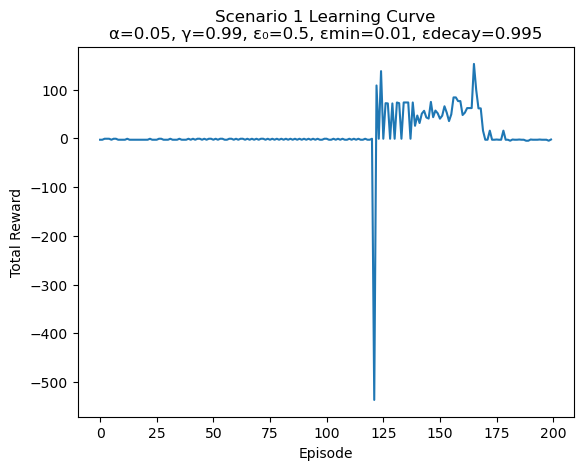

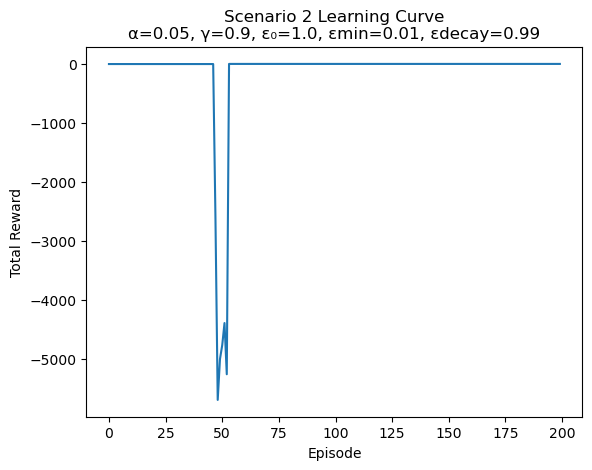

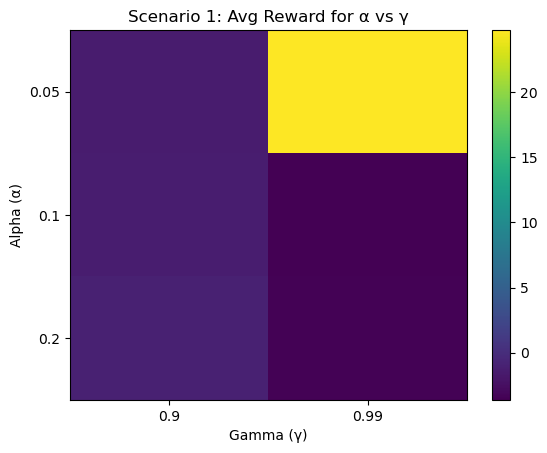

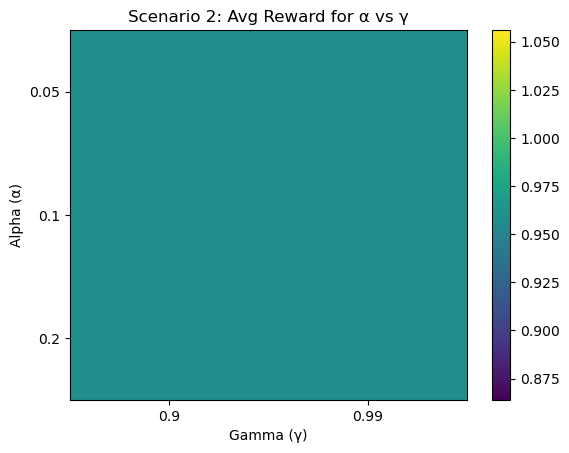

In [21]:
# ── Hyperparameter Grid Search for Q-Learning Agent (Scenarios 1 & 2) ──

def discretize(observation):
   
    return tuple(int(v) for v in observation)


def train_q_learning(env, num_episodes, max_steps,
                     alpha, gamma,
                     epsilon_start, epsilon_min, epsilon_decay):
    Q = {}
    epsilon = epsilon_start
    rewards_history = []
    for ep in range(num_episodes):
        obs, _ = env.reset()
        state = discretize(obs)
        total_reward = 0
        for _ in range(max_steps):
            if state not in Q:
                Q[state] = np.zeros(env.action_space.n)
            # ε-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = int(np.argmax(Q[state]))
            obs_next, reward, done, *_ = env.step(action)
            next_state = discretize(obs_next)
            if next_state not in Q:
                Q[next_state] = np.zeros(env.action_space.n)
            # Q-learning update
            Q[state][action] += alpha * (
                reward + gamma * np.max(Q[next_state])
                - Q[state][action]
            )
            state = next_state
            total_reward += reward
            if done:
                break
        rewards_history.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
    return Q, rewards_history

# 2) Define hyperparameter ranges
alphas         = [0.05, 0.1, 0.2]
gammas         = [0.9, 0.99]
epsilon_starts = [1.0, 0.5]
epsilon_mins   = [0.01, 0.05]
epsilon_decays = [0.99, 0.995]

num_episodes = 200
max_steps    = 100

# 3) Perform grid search
results = []
for scenario in [1, 2]:
    for alpha in alphas:
        for gamma in gammas:
            for eps0 in epsilon_starts:
                for eps_min in epsilon_mins:
                    for eps_decay in epsilon_decays:
                        env = PacketSchedulerEnv(
                            scenario=scenario,
                            arrival_probs=(0.3, 0.25, 0.4),
                            seed=0
                        )
                        _, rewards = train_q_learning(
                            env, num_episodes, max_steps,
                            alpha, gamma,
                            eps0, eps_min, eps_decay
                        )
                        avg_reward = np.mean(rewards[-50:])
                        results.append({
                            'scenario': scenario,
                            'alpha': alpha,
                            'gamma': gamma,
                            'epsilon_start': eps0,
                            'epsilon_min': eps_min,
                            'epsilon_decay': eps_decay,
                            'avg_reward': avg_reward
                        })

# 4) Display the results table
df = pd.DataFrame(results)
#ace_tools.display_dataframe_to_user("Grid Search Results for Q-Learning", df)

# 5) Identify and print best hyperparameters per scenario
best = df.loc[df.groupby('scenario')['avg_reward'].idxmax()]
for _, row in best.iterrows():
    print(f"Scenario {int(row['scenario'])} best config:")
    print(f"  α={row['alpha']}, γ={row['gamma']}, "
          f"ε₀={row['epsilon_start']}, εmin={row['epsilon_min']}, "
          f"εdecay={row['epsilon_decay']} → Avg Reward={row['avg_reward']:.2f}\n")

# 6) Plot learning curves for the best configurations
for _, row in best.iterrows():
    env = PacketSchedulerEnv(
        scenario=int(row['scenario']),
        arrival_probs=(0.3, 0.25, 0.4),
        seed=0
    )
    _, rewards = train_q_learning(
        env, num_episodes, max_steps,
        row['alpha'], row['gamma'],
        row['epsilon_start'], row['epsilon_min'], row['epsilon_decay']
    )
    plt.figure()
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title(
        f"Scenario {int(row['scenario'])} Learning Curve\n"
        f"α={row['alpha']}, γ={row['gamma']}, "
        f"ε₀={row['epsilon_start']}, εmin={row['epsilon_min']}, "
        f"εdecay={row['epsilon_decay']}"
    )
    plt.show()

# 7) Example heatmaps for α vs γ at the best ε settings
for scenario in [1, 2]:
    best_row = best[best['scenario'] == scenario].iloc[0]
    subset = df[
        (df['scenario'] == scenario) &
        (df['epsilon_start'] == best_row['epsilon_start']) &
        (df['epsilon_min']   == best_row['epsilon_min'])   &
        (df['epsilon_decay']== best_row['epsilon_decay'])
    ]
    pivot = subset.pivot(index='alpha', columns='gamma', values='avg_reward')
    plt.figure()
    plt.imshow(pivot.values, aspect='auto')
    plt.xticks(range(len(pivot.columns)), pivot.columns)
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xlabel('Gamma (γ)')
    plt.ylabel('Alpha (α)')
    plt.title(f'Scenario {scenario}: Avg Reward for α vs γ')
    plt.colorbar()
    plt.show()

In [44]:
# ─────────────────────────────────────────────────────────────────────────────
# Tabular Q-Learning for PacketSchedulerEnv (scenario 1)
# ─────────────────────────────────────────────────────────────────────────────
SEED = 42

# 1) Create the environment
env = PacketSchedulerEnv(scenario=1, seed = SEED)

# 2) Q-table: maps state (tuple) → array of action-values
Q1 = defaultdict(lambda: np.zeros(env.action_space.n))

# 3) Hyperparameters
alpha         = 0.5    # learning rate
gamma         = 0.99   # discount factor
epsilon       = 0.5    # initial exploration rate
epsilon_min   = 0.01   # minimum ε
epsilon_decay = 0.9  # multiplicative decay per episode
num_episodes  = 2000
max_steps     = 150    # max steps per episode

# 4) Training loop
for ep in range(1, num_episodes+1):
    obs, _ = env.reset(seed=SEED + ep)
    state = tuple(obs)            # cast observation to immutable
    total_reward = 0.0

    for t in range(max_steps):
        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = int(np.argmax(Q1[state]))

        # take action
        obs2, reward, done, truncated, info = env.step(action)
        next_state = tuple(obs2)
        total_reward += reward

        # Q-learning update
        best_next = np.max(Q[next_state])
        td_target = reward + gamma * best_next
        Q1[state][action] += alpha * (td_target - Q1[state][action])

        state = next_state
        if done or truncated:
            break

    # decay ε
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    stats = env.get_statistics()
    if ep % 100 == 0:
        print(f"Episode {ep}/{num_episodes}  total_reward={total_reward:.1f}  ε={epsilon:.3f}")

Episode 100/2000  total_reward=84.7  ε=0.010
Episode 200/2000  total_reward=1.2  ε=0.010
Episode 300/2000  total_reward=13.6  ε=0.010
Episode 400/2000  total_reward=-926.7  ε=0.010
Episode 500/2000  total_reward=-2.8  ε=0.010
Episode 600/2000  total_reward=64.6  ε=0.010
Episode 700/2000  total_reward=277.7  ε=0.010
Episode 800/2000  total_reward=170.0  ε=0.010
Episode 900/2000  total_reward=3.5  ε=0.010
Episode 1000/2000  total_reward=7.9  ε=0.010
Episode 1100/2000  total_reward=1.0  ε=0.010
Episode 1200/2000  total_reward=144.2  ε=0.010
Episode 1300/2000  total_reward=2.8  ε=0.010
Episode 1400/2000  total_reward=0.7  ε=0.010
Episode 1500/2000  total_reward=20.7  ε=0.010
Episode 1600/2000  total_reward=-0.8  ε=0.010
Episode 1700/2000  total_reward=-0.8  ε=0.010
Episode 1800/2000  total_reward=0.3  ε=0.010
Episode 1900/2000  total_reward=4.0  ε=0.010
Episode 2000/2000  total_reward=-4.8  ε=0.010


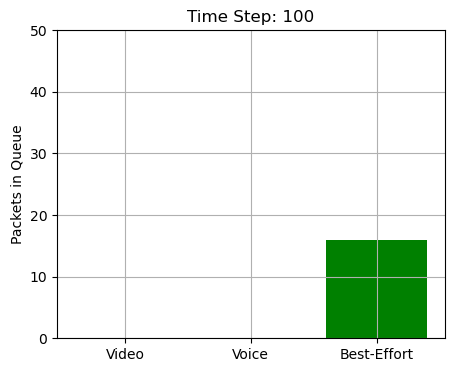

Trained Q-Learning policy results: {'queue_lengths': [0, 0, 16], 'arrivals': [29, 20, 48], 'served': [29, 20, 32], 'mean_delays': [1.2413793103448276, 1.75, 22.34375], 'qos_violations': [0, 1], 'violation_rates': [0.0, 0.05], 'empty_queue_penalty_count': 19}


In [45]:
# 5) Evaluate the learned policy
obs, _ = env.reset(seed=SEED)
state = tuple(obs)
for t in range(100):
    action = int(np.argmax(Q1[state]))
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()
    time.sleep(0.1)
    state = tuple(obs)
    if done or truncated:
        break

print("Trained Q-Learning policy results:", env.get_statistics())

In [26]:
def coarse_bin_length(length, max_size=50):
    if length == 0:
        return 0
    elif length <= max_size * 0.2:
        return 1
    elif length <= max_size * 0.7:
        return 2
    else:
        return 3

def coarse_bin_slack(slack, qos_limit):
    # -2 = expired, -1 = urgent, 0 = approaching, 1 = safe, 2 = plenty
    if slack <= 0:
        return -2
    elif slack < qos_limit * 0.2:
        return -1
    elif slack < qos_limit * 0.5:
        return 0
    elif slack < qos_limit * 0.8:
        return 1
    else:
        return 2

def get_coarse_state(env):
    len0 = coarse_bin_length(len(env.queues[0]), env.max_queue_size)
    len1 = coarse_bin_length(len(env.queues[1]), env.max_queue_size)
    len2 = coarse_bin_length(len(env.queues[2]), env.max_queue_size)
    slack0 = env.qos_limits[0] - (env.time - env.queues[0][0]) if env.queues[0] else env.qos_limits[0]
    slack1 = env.qos_limits[1] - (env.time - env.queues[1][0]) if env.queues[1] else env.qos_limits[1]
    slack_bin0 = coarse_bin_slack(slack0, env.qos_limits[0])
    slack_bin1 = coarse_bin_slack(slack1, env.qos_limits[1])
    return (env.current_queue, len0, len1, len2, slack_bin0, slack_bin1)

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Q-Learning for PacketSchedulerEnv (scenario 2)
# ─────────────────────────────────────────────────────────────────────────────
SEED = 42

env = PacketSchedulerEnv(scenario=2, seed=SEED)
Q2 = defaultdict(lambda: np.zeros(env.action_space.n))

alpha         = 0.05
gamma         = 0.9
epsilon       = 1.0
epsilon_min   = 0.1
epsilon_decay = 0.99
num_episodes  = 10000
max_steps     = 250

# for logging and graph
episode_rewards = []
violation_rates_video = []
violation_rates_voice = []
empty_serve_counts = []

for ep in range(1, num_episodes + 1):
    obs, _ = env.reset(seed=SEED + ep)
    state = get_coarse_state(env)
    total_reward = 0

    for t in range(max_steps):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = int(np.argmax(Q[state]))

        obs2, reward, done, truncated, _ = env.step(action)
        next_state = get_coarse_state(env)
        total_reward += reward

        # Q-learning update
        best_next = np.max(Q[next_state])
        Q2[state][action] += alpha * (reward + gamma * best_next - Q2[state][action])

        state = next_state
        if done or truncated:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    # for logs and plots
    stats = env.get_statistics()
    episode_rewards.append(total_reward)
    violation_rates_video.append(stats['violation_rates'][0])
    violation_rates_voice.append(stats['violation_rates'][1])
    empty_serve_counts.append(stats['empty_queue_penalty_count'])
    if ep % 500 == 0:
        stats = env.get_statistics()
        print(f"Episode {ep}/{num_episodes} | Reward: {total_reward:.2f} | "
              f"Video Violation: {stats['violation_rates'][0]:.2f} | "
              f"Voice Violation: {stats['violation_rates'][1]:.2f} | "
              f"Epsilon: {epsilon:.3f}")


Episode 500/10000 | Reward: -34807.03 | Video Violation: 0.20 | Voice Violation: 1.00 | Epsilon: 0.100
Episode 1000/10000 | Reward: -34443.02 | Video Violation: 0.21 | Voice Violation: 0.86 | Epsilon: 0.100
Episode 1500/10000 | Reward: -37401.10 | Video Violation: 0.78 | Voice Violation: 1.00 | Epsilon: 0.100
Episode 2000/10000 | Reward: -35646.45 | Video Violation: 0.88 | Voice Violation: 0.60 | Epsilon: 0.100
Episode 2500/10000 | Reward: -29463.90 | Video Violation: 0.03 | Voice Violation: 0.80 | Epsilon: 0.100
Episode 3000/10000 | Reward: 3.00 | Video Violation: 0.00 | Voice Violation: 0.00 | Epsilon: 0.100
Episode 3500/10000 | Reward: -29414.00 | Video Violation: 0.29 | Voice Violation: 0.88 | Epsilon: 0.100
Episode 4000/10000 | Reward: -24706.35 | Video Violation: 1.00 | Voice Violation: 0.07 | Epsilon: 0.100
Episode 4500/10000 | Reward: -26295.95 | Video Violation: 0.14 | Voice Violation: 0.77 | Epsilon: 0.100
Episode 5000/10000 | Reward: -27208.10 | Video Violation: 0.27 | Voice

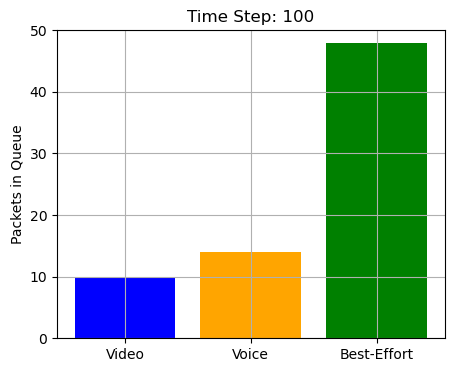

Trained Q-Learning policy results scenario 2 binned:
 {'queue_lengths': [10, 14, 48], 'arrivals': [29, 20, 48], 'served': [19, 6, 0], 'mean_delays': [3.263157894736842, 19.666666666666668, None], 'qos_violations': [0, 2], 'violation_rates': [0.0, 0.3333333333333333], 'empty_queue_penalty_count': 1}


In [ ]:
# Evaluation
obs, _ = env.reset(seed=SEED)
state = get_coarse_state(env)
for t in range(100):
    action = int(np.argmax(Q2[state]))
    obs, reward, done, truncated, info = env.step(action)
    env.draw_network_queue()  # Optional: visualize
    state = get_coarse_state(env)
    if done or truncated:
        break
print("Trained Q-Learning policy results scenario 2 binned:\n", env.get_statistics())

In [29]:
print("Trained Q-Learning policy results scenario 2\n:", env.get_statistics())

Trained Q-Learning policy results scenario 2
: {'queue_lengths': [10, 14, 48], 'arrivals': [29, 20, 48], 'served': [19, 6, 0], 'mean_delays': [3.263157894736842, 19.666666666666668, None], 'qos_violations': [0, 2], 'violation_rates': [0.0, 0.3333333333333333], 'empty_queue_penalty_count': 1}


# Evaluation

### Baseline Scheduling Policies

To help evaluate our learned Q-learning agent, we will compare against three classic heuristics. Each policy makes decisions based on simple, deterministic rules—no learning or reward tuning required.

#### 1. First-In-First-Out (FIFO)
- **Mechanism:**  
  At each step, inspect the front (oldest) packet in each nonempty queue and choose the one with the earliest arrival timestamp.  
- **Rationale:**  
  Simple fairness: packets are served in the exact order they arrived, regardless of class or deadline.  
- **Strengths:**  
  - Very easy to implement and analyse.  
  - Provides a baseline for total system throughput and average delay.  
- **Limitations:**  
  - Ignores deadlines: late‐deadline packets may wait arbitrarily long behind new arrivals in other queues.  
  - No awareness of QoS class priorities: video, voice, and best‐effort traffic are treated identically.

#### 2. Earliest-Deadline-First (EDF)
- **Mechanism:**  
  For each queue \(i\), compute the current slack (i.e difference between current wait time and deadline requirement). Then serve the packet with the smallest (most urgent) slack.  
- **Rationale:**  
  Minimizes deadline misses by always addressing the packet closest to its deadline.  
- **Strengths:**  
  - Provides strong deadline-compliance for hard-QoS traffic (P1 and P2).  
  - Automatically deprioritises best-effort (P3) when hard-QoS packets are near expiry.  
- **Limitations:**  
  - No built-in fairness: a burst of P1/P2 arrivals can starve P3 indefinitely.  
  - Does not explicitly weigh long-term throughput versus immediate deadlines.

#### 3. Sequential Priority
- **Mechanism:**  
  At each time step, scan queues in fixed order P2 → P1 → P3 and serve the first non-empty one.  
- **Rationale:**  
  Enforces strict class priority: voice traffic (P2) always goes first; if there are no P1 packets, serve video (P1); otherwise serve best-effort (P3).  
- **Strengths:**  
  - Guarantees zero deadline misses for P1 and P2 (hard QoS) when arrival rates permit.  
  - Extremely low computational overhead.  
- **Limitations:**  
  - Can severely starve lower classes: P3 may see zero service if P1/P2 are backlogged.  
  - No consideration for packet age or accumulated delay—late P2 packets might still block P3 even if their own deadlines are already missed.

---

By comparing against these baselines, we can quantify the gains of our adaptive Q-learning policy in terms of throughput, delay, deadline compliance, and fairness across traffic classes.  

In [48]:
## helper methods to run baselines
def run_fifo(env, steps, visualise = False):
    '''Runs baseline FIFO policy on a given environment'''
    for _ in range(steps):
        arrival_times = [q[0] if len(q) > 0 else float('inf') for q in env.queues]
        action = int(np.argmin(arrival_times))
        obs, reward, done, truncated, info = env.step(action)
        if visualise == True:
            env.draw_network_queue()
            time.sleep(0.1)
        if done or truncated:
            break
    return env.get_statistics()

def run_edf(env, steps, visualise = False):
    '''Runs baseline EDF policy for given environment'''
    mean_reqs = env.qos_limits
    for _ in range(steps):
        slacks = []
        for i, q in enumerate(env.queues):
            if q and (mean_reqs[i] is not None):
                arrival_time = q[0]
                acc_delay = env.time - arrival_time
                slack = mean_reqs[i] - acc_delay
            else:
                slack = float('inf')
            slacks.append(slack)
        action = int(np.argmin(slacks))
        obs, reward, done, truncated, info = env.step(action)
        if visualise == True:
            env.draw_network_queue()
            time.sleep(0.1)
        if done or truncated:
            break
    return env.get_statistics()

def run_sequential_priority(env, steps, visualise = False):
    '''Runs sequential priority policy on given environment'''
    for _ in range(steps):
        action = None
        for q_idx in range(env.num_queues):
            if env.queues[q_idx]:
                action = q_idx
                break
        if action is None:
            action = 0
        obs, reward, done, truncated, info = env.step(action)
        if visualise == True:
            env.draw_network_queue()
            time.sleep(0.1)
        if done or truncated:
            break
    return env.get_statistics()

def run_q_learning_agent(env, steps, Q, state_fn):
    '''Runs the Q-Learning agent'''
    obs, _ = env.reset()
    state = state_fn(env)
    for _ in range(steps):
        action = int(np.argmax(Q[state]))
        obs, reward, done, truncated, info = env.step(action)
        state = state_fn(env)
        if done or truncated:
            break
    return env.get_statistics()

### Validation of Baseline Policy Implementations

The following code cell verifies that each scheduling heuristic—FIFO, EDF, and Sequential Priority—matches its intended behavior. For each policy we:

1. **Disable arrivals** (`arrival_rates=(0,0,0)`) so that only the policy’s decisions change queue lengths.  
2. **Set up** specific queue states with easily distinguishable packet counts or timestamps.  
3. **Run** the policy for a few steps, capturing which queue index is served at each step.  
4. **Compare** the observed service sequence to the expected order:  
   - **FIFO:** Serve the queue with the earliest packet arrival.  
   - **EDF:** Serve the queue with the smallest deadline slack.  
   - **Sequential Priority:** Serve P1 until empty, then P2, then P3.  
5. **Assert** correctness or raise an error if the policy deviates.  

Passing these tests confirms that our baseline helper functions behave exactly as described before evaluating their performance.

In [ ]:
# Validation tests for baseline scheduling policies

def get_served_sequence(env, run_fn, steps):
    """
    Run the given baseline policy for `steps` iterations,
    returning the index of the queue served at each step.
    """
    seq = []
    for _ in range(steps):
        before = [len(q) for q in env.queues]
        run_fn(env, 1)
        after = [len(q) for q in env.queues]
        # Identify which queue length decreased by exactly one
        served_idx = next(i for i, (b, a) in enumerate(zip(before, after)) if a == b - 1)
        seq.append(served_idx)
    return seq

# 1) FIFO Test
env_fifo = PacketSchedulerEnv(scenario=1, arrival_probs=(0,0,0), seed=0)
env_fifo.reset()
env_fifo.queues = [[3], [1], [2]]  # distinct single-packet queues
fifo_seq = get_served_sequence(env_fifo, run_fifo, 3)
print("FIFO served order (expected [1, 2, 0]):", fifo_seq)
assert fifo_seq == [1, 2, 0], "FIFO policy implementation is incorrect"

# 2) EDF Test
env_edf = PacketSchedulerEnv(scenario=1, arrival_probs=(0,0,0), seed=0)
env_edf.reset()
env_edf.queues = [[0], [0], [0]]   # identical arrival times
edf_seq = get_served_sequence(env_edf, run_edf, 2)
print("EDF served order (expected [1, 0]):", edf_seq)
assert edf_seq == [1, 0], "EDF policy implementation is incorrect"

# 3) Sequential Priority Test
env_seq = PacketSchedulerEnv(scenario=1, arrival_probs=(0,0,0), seed=0)
env_seq.reset()
env_seq.queues = [[0,0], [0], [0]]  # two P1, one P2, one P3
seq_seq = get_served_sequence(env_seq, run_sequential_priority, 3)
print("Sequential Priority served order (expected [0, 0, 1]):", seq_seq)
assert seq_seq == [0, 0, 1], "Sequential Priority implementation is incorrect"

FIFO served order (expected [1, 2, 0]): [1, 2, 0]
EDF served order (expected [1, 0]): [1, 0]
Sequential Priority served order (expected [0, 0, 1]): [0, 0, 1]
✅ All baseline policies validated successfully.


In [ ]:
def evaluate_policies(env_class, scenario, arrival_probs, steps, num_runs, Q=None, state_fn=None):
    '''Evaluates baselines and Q-policy'''
    results = defaultdict(list)
    for seed in range(num_runs):
        # FIFO
        env = env_class(scenario=scenario, arrival_probs=arrival_probs, seed=seed)
        env.reset(seed=seed)
        results['FIFO'].append(run_fifo(env, steps))
        # EDF
        env = env_class(scenario=scenario, arrival_probs=arrival_probs, seed=seed)
        env.reset(seed=seed)
        results['EDF'].append(run_edf(env, steps))
        # SP
        env = env_class(scenario=scenario, arrival_probs=arrival_probs, seed=seed)
        env.reset(seed=seed)
        results['SP'].append(run_sequential_priority(env, steps))
        # Q Learning
        if Q is not None and state_fn is not None:
            env = env_class(scenario=scenario, arrival_probs=arrival_probs, seed=seed)
            env.reset(seed=seed)
            results['Q Learning Policy'].append(run_q_learning_agent(env, steps, Q, state_fn))
    return results

def get_policy_run_results(results):
    '''Combines results from policy runs for statistics'''
    aggregate_results = {}
    for pol, res_list in results.items():
        delay_BE = [r['mean_delays'][2] if r['mean_delays'][2] is not None else 0 for r in res_list]
        viol_vid = [r['violation_rates'][0] for r in res_list]
        viol_vo = [r['violation_rates'][1] for r in res_list]
        aggregate_results[pol] = {
            'mean_delay_BE': (np.mean(delay_BE), np.std(delay_BE)),
            'viol_vid': (np.mean(viol_vid), np.std(viol_vid)),
            'viol_vo': (np.mean(viol_vo), np.std(viol_vo)),
        }
    #print("get_policy_run_results input:", results)
    return aggregate_results


In [158]:
# Testing the policies on different arrival rates.
# original, high video packets, high voice packets, and high Best effort packets

#list of rates
packet_arrival_probs = [
    [0.3, 0.25, 0.4],   
    [0.5, 0.3, 0.3],     
    [0.2, 0.5, 0.4],     
    [0.4, 0.4, 0.6],     
]
rate_labels = ['Original', 'Video', 'Voice', 'Best-Effort']

In [160]:
def batch_eval(env_class, scenario, arrival_rate_grid, steps, num_runs, Q=None, state_fn=None):
    '''evaluate all policies for different packet arrival rates'''
    all_results = []
    for arrival_probs in arrival_rate_grid:
        agg = get_policy_run_results(
            evaluate_policies(
                env_class,
                scenario,
                arrival_probs,
                steps,
                num_runs,
                Q=Q,
                state_fn=state_fn
            )
        )
        all_results.append(agg)
    return all_results

In [ ]:
def plot_line_comparison(all_results, rate_labels, scenario_label):
    metrics = [
        ('mean_delay_BE', 'Mean Delay (Best Effort)'),
        ('viol_vid', 'Video Violation Rate'),
        ('viol_vo', 'Voice Violation Rate')
    ]
    policies = list(all_results[0].keys())
    x = np.arange(len(rate_labels))
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    for idx, (metric_key, ylabel) in enumerate(metrics):
        ax = axs[idx]
        has_any = False
        for pol in policies:
            y = [res[pol][metric_key][0] if res[pol][metric_key][0] is not None else np.nan for res in all_results]
            y_err = [res[pol][metric_key][1] if res[pol][metric_key][1] is not None else 0 for res in all_results]
            if not all(np.isnan(yv) for yv in y):
                ax.errorbar(x, y, yerr=y_err, marker='o', label=pol, capsize=4)
                has_any = True
        ax.set_xticks(x)
        ax.set_xticklabels(rate_labels, rotation=15)
        ax.set_xlabel("Arrival Rate Scenario")
        ax.set_ylabel(ylabel)
        ax.set_title(ylabel)
        ax.grid(True, axis='y')
        if has_any:
            ax.legend()
    plt.suptitle(f"Policy Comparison for Different Arrival Rates (Scenario {scenario_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

get_policy_run_results input: defaultdict(<class 'list'>, {'FIFO': [{'queue_lengths': [0, 0, 0], 'arrivals': [2, 1, 3], 'served': [2, 1, 3], 'mean_delays': [1.0, 2.0, 2.0], 'qos_violations': [0, 0], 'violation_rates': [0.0, 0.0], 'empty_queue_penalty_count': 2}, {'queue_lengths': [0, 0, 0], 'arrivals': [0, 1, 2], 'served': [0, 1, 2], 'mean_delays': [None, 1.0, 1.5], 'qos_violations': [0, 0], 'violation_rates': [0.0, 0.0], 'empty_queue_penalty_count': 1}, {'queue_lengths': [0, 0, 0], 'arrivals': [1, 0, 0], 'served': [1, 0, 0], 'mean_delays': [0.0, None, None], 'qos_violations': [0, 0], 'violation_rates': [0.0, 0.0], 'empty_queue_penalty_count': 0}, {'queue_lengths': [0, 0, 0], 'arrivals': [4, 2, 6], 'served': [4, 2, 6], 'mean_delays': [1.25, 2.5, 1.5], 'qos_violations': [0, 0], 'violation_rates': [0.0, 0.0], 'empty_queue_penalty_count': 0}, {'queue_lengths': [2, 3, 3], 'arrivals': [40, 34, 53], 'served': [38, 31, 50], 'mean_delays': [6.157894736842105, 6.67741935483871, 6.36], 'qos_viol

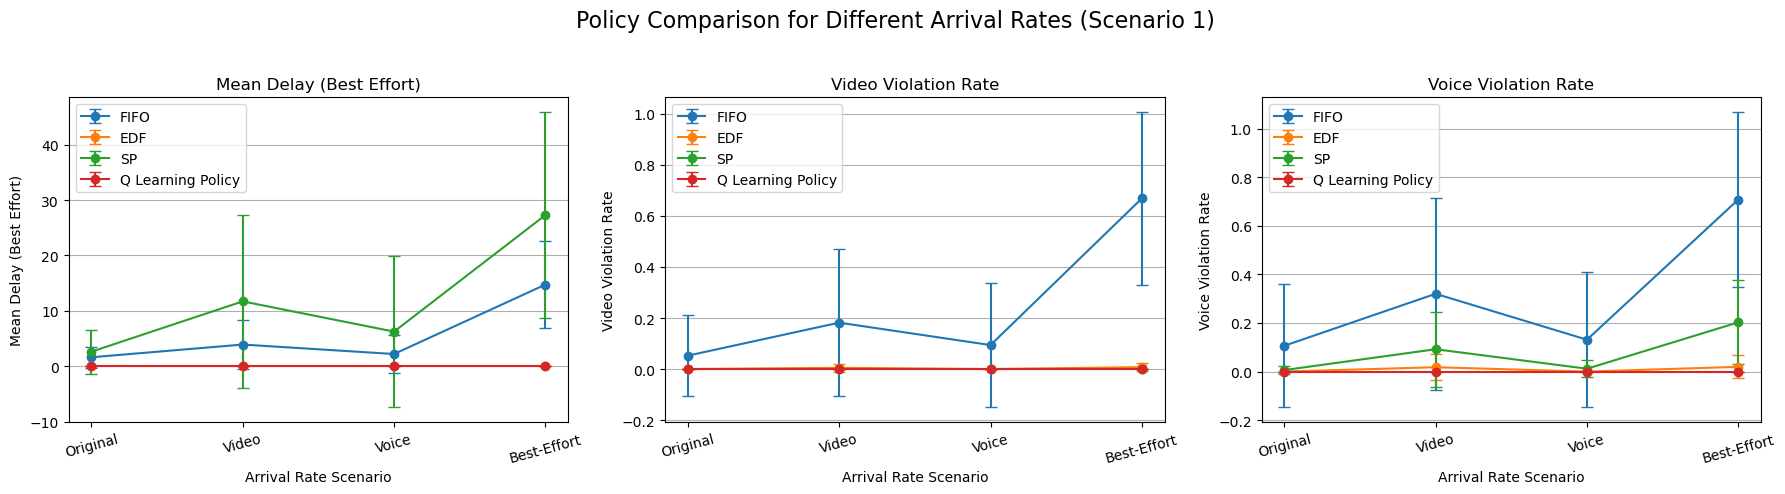

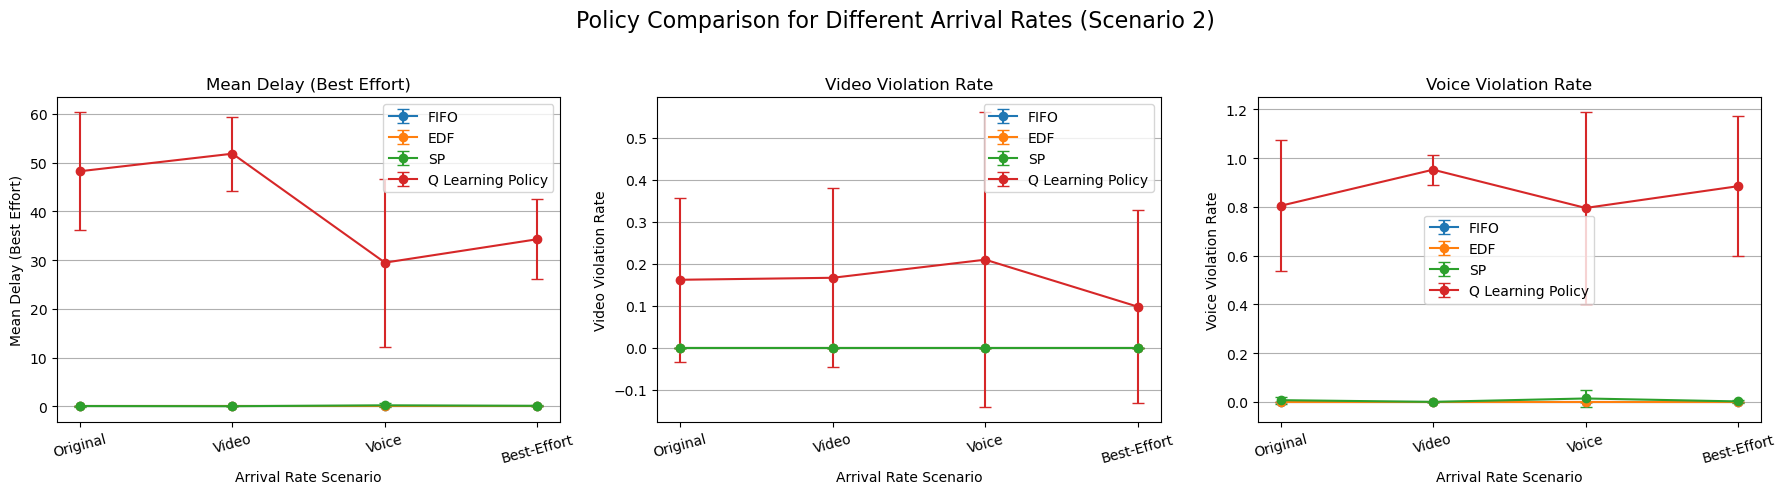

In [ ]:
# calling the methods for evaluation and graph generation
store_results_scenario_1 = batch_eval(PacketSchedulerEnv, scenario=1, arrival_rate_grid=packet_arrival_probs,
                                      steps=120, num_runs=10, Q=Q1, state_fn=lambda env: tuple(env.get_observations()))
store_results_scenario_2 = batch_eval(PacketSchedulerEnv, scenario=2, arrival_rate_grid=packet_arrival_probs,
steps=120, num_runs=10, Q=Q2, state_fn=get_coarse_state)

plot_line_comparison(store_results_scenario_1, rate_labels, scenario_label=1)
plot_line_comparison(store_results_scenario_2, rate_labels, scenario_label=2)